##### Import the libraries

In [ ]:
pip install tensorflow_datasets

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

##### Read the dataset : imdb reviews

In [7]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [8]:
train_data, test_data = imdb['train'], imdb['test']

In [9]:
type(train_data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [10]:
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
for s,l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

In [11]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/home/mitu/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,

In [12]:
training_sentences[3]

"b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.'"

In [13]:
training_labels[3]

1

In [14]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [15]:
len(training_sentences), len(testing_sentences)

(25000, 25000)

In [16]:
training_labels_final.size, testing_labels_final.size

(25000, 25000)

In [17]:
vocab_size = 10000
embedding_dim=16
max_length = 120
trunc_type= 'post'

In [18]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
word_index;
len(word_index)

86538

In [20]:
word_index;

In [21]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length,
                       truncating = trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [23]:
len(sequences)

25000

In [25]:
len(sequences[0])

110

In [27]:
len(padded[0])

120

In [29]:
padded.shape

(25000, 120)

In [31]:
testing_padded.shape

(25000, 120)

In [32]:
padded.dtype

dtype('int32')

##### Build the SimpleRNN Model

In [39]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding

In [40]:
model_rnn = Sequential([
    Embedding(vocab_size, embedding_dim,
                             input_length=max_length),
    SimpleRNN(32),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1568      
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 161909 (632.46 KB)
Trainable params: 161909 (632.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Compile the RNN model

In [43]:
model_rnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [44]:
history = model_rnn.fit(padded, training_labels_final, epochs=10,
                  validation_data = (testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 16s 19ms/step - loss: 0.6786 - accuracy: 0.5512 - val_loss: 0.5499 - val_accuracy: 0.7302
Epoch 2/10
782/782 [==============================] - 15s 19ms/step - loss: 0.5417 - accuracy: 0.7334 - val_loss: 0.4778 - val_accuracy: 0.7928
Epoch 3/10
782/782 [==============================] - 15s 19ms/step - loss: 0.3849 - accuracy: 0.8380 - val_loss: 0.4764 - val_accuracy: 0.8058
Epoch 4/10
782/782 [==============================] - 15s 19ms/step - loss: 0.2940 - accuracy: 0.8844 - val_loss: 0.4395 - val_accuracy: 0.8238
Epoch 5/10
782/782 [==============================] - 15s 19ms/step - loss: 0.2302 - accuracy: 0.9118 - val_loss: 0.4806 - val_accuracy: 0.8266
Epoch 6/10
782/782 [==============================] - 16s 21ms/step - loss: 0.1559 - accuracy: 0.9448 - val_loss: 0.5475 - val_accuracy: 0.8193
Epoch 7/10
782/782 [==============================] - 17s 21ms/step - loss: 0.1033 - accuracy: 0.9649 - val_loss: 0.7284 - val_accuracy:

In [48]:
import matplotlib.pyplot as plt

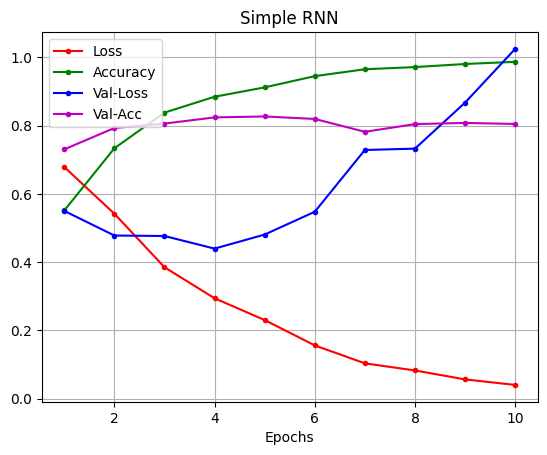

In [57]:
plt.title('Simple RNN')
plt.xlabel('Epochs')
plt.grid()
plt.plot(range(1,11), history.history['loss'], color = 'r', label = 'Loss', marker='.')
plt.plot(range(1,11), history.history['accuracy'], color = 'g', label = 'Accuracy',marker='.')
plt.plot(range(1,11), history.history['val_loss'], color = 'b', label = 'Val-Loss',marker='.')
plt.plot(range(1,11), history.history['val_accuracy'], color = 'm', label = 'Val-Acc',marker='.')
plt.legend(loc='upper left')

In [46]:
history.history

{'loss': [0.6785768866539001,
  0.5417090058326721,
  0.38489457964897156,
  0.2939601242542267,
  0.23019923269748688,
  0.1558753252029419,
  0.10329405963420868,
  0.08246032893657684,
  0.056264542043209076,
  0.040092162787914276],
 'accuracy': [0.5511599779129028,
  0.7333999872207642,
  0.8379600048065186,
  0.8844000101089478,
  0.91184002161026,
  0.9447600245475769,
  0.9649199843406677,
  0.9713199734687805,
  0.9803599715232849,
  0.9867200255393982],
 'val_loss': [0.5499120354652405,
  0.4777889549732208,
  0.47636815905570984,
  0.43945062160491943,
  0.48064208030700684,
  0.5474814176559448,
  0.7284340858459473,
  0.7323278188705444,
  0.8672274351119995,
  1.0245048999786377],
 'val_accuracy': [0.730239987373352,
  0.7927600145339966,
  0.8057600259780884,
  0.8238400220870972,
  0.8266400098800659,
  0.819320023059845,
  0.781719982624054,
  0.8041999936103821,
  0.8077200055122375,
  0.804639995098114]}

##### Build the model for LSTM

In [59]:
from keras.layers import Bidirectional, GRU, LSTM

In [61]:
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(32)),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                12544     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 173205 (676.58 KB)
Trainable params: 173205 (676.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Compile LSTM model

In [64]:
model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

##### Train LSTM model

In [66]:
history_lstm = model_lstm.fit(padded, training_labels_final, epochs=10,
                  validation_data = (testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 40s 49ms/step - loss: 0.4655 - accuracy: 0.7729 - val_loss: 0.3478 - val_accuracy: 0.8514
Epoch 2/10
782/782 [==============================] - 38s 49ms/step - loss: 0.2943 - accuracy: 0.8837 - val_loss: 0.3726 - val_accuracy: 0.8474
Epoch 3/10
782/782 [==============================] - 39s 50ms/step - loss: 0.2266 - accuracy: 0.9142 - val_loss: 0.4234 - val_accuracy: 0.8407
Epoch 4/10
782/782 [==============================] - 41s 52ms/step - loss: 0.1814 - accuracy: 0.9329 - val_loss: 0.4328 - val_accuracy: 0.8356
Epoch 5/10
782/782 [==============================] - 41s 52ms/step - loss: 0.1412 - accuracy: 0.9518 - val_loss: 0.5300 - val_accuracy: 0.8303
Epoch 6/10
782/782 [==============================] - 41s 53ms/step - loss: 0.1121 - accuracy: 0.9627 - val_loss: 0.5482 - val_accuracy: 0.8284
Epoch 7/10
782/782 [==============================] - 41s 52ms/step - loss: 0.0889 - accuracy: 0.9701 - val_loss: 0.7252 - val_accuracy:

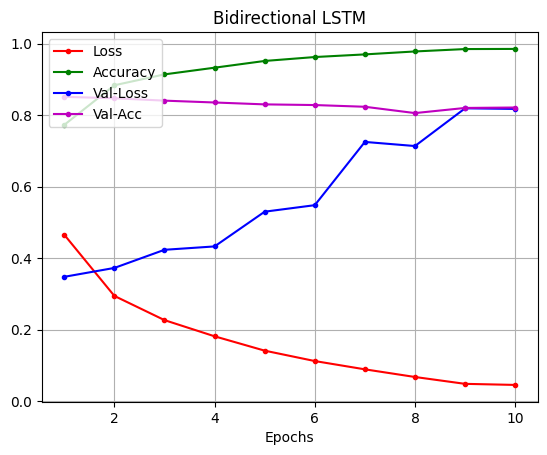

In [67]:
plt.title('Bidirectional LSTM')
plt.xlabel('Epochs')
plt.grid()
plt.plot(range(1,11), history_lstm.history['loss'], color = 'r', label = 'Loss', marker='.')
plt.plot(range(1,11), history_lstm.history['accuracy'], color = 'g', label = 'Accuracy',marker='.')
plt.plot(range(1,11), history_lstm.history['val_loss'], color = 'b', label = 'Val-Loss',marker='.')
plt.plot(range(1,11), history_lstm.history['val_accuracy'], color = 'm', label = 'Val-Acc',marker='.')
plt.legend(loc='upper left')

##### Build model for GRU

In [69]:
model_gru = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(32)),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                9600      
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 170261 (665.08 KB)
Trainable params: 170261 (665.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Compile GRU model

In [71]:
model_gru.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

##### Train GRU model

In [74]:
history_gru = model_gru.fit(padded, training_labels_final, epochs=10,
                  validation_data = (testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 44s 54ms/step - loss: 0.4952 - accuracy: 0.7402 - val_loss: 0.3454 - val_accuracy: 0.8504
Epoch 2/10
782/782 [==============================] - 42s 54ms/step - loss: 0.2953 - accuracy: 0.8830 - val_loss: 0.3474 - val_accuracy: 0.8497
Epoch 3/10
782/782 [==============================] - 46s 59ms/step - loss: 0.2335 - accuracy: 0.9122 - val_loss: 0.4125 - val_accuracy: 0.8342
Epoch 4/10
782/782 [==============================] - 45s 57ms/step - loss: 0.1893 - accuracy: 0.9323 - val_loss: 0.3903 - val_accuracy: 0.8397
Epoch 5/10
782/782 [==============================] - 45s 58ms/step - loss: 0.1471 - accuracy: 0.9498 - val_loss: 0.4643 - val_accuracy: 0.8340
Epoch 6/10
782/782 [==============================] - 45s 58ms/step - loss: 0.1079 - accuracy: 0.9648 - val_loss: 0.5348 - val_accuracy: 0.8268
Epoch 7/10
782/782 [==============================] - 46s 58ms/step - loss: 0.0761 - accuracy: 0.9770 - val_loss: 0.5712 - val_accuracy:

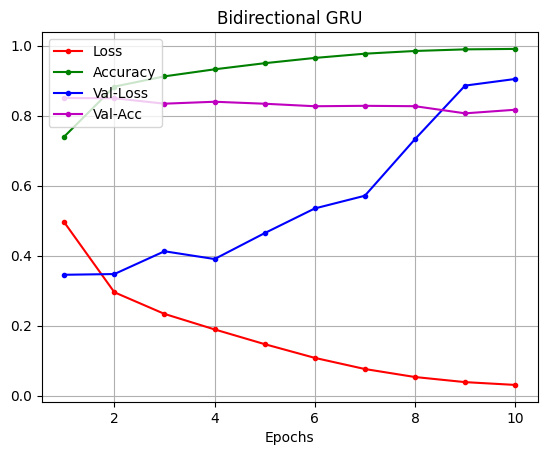

In [75]:
plt.title('Bidirectional GRU')
plt.xlabel('Epochs')
plt.grid()
plt.plot(range(1,11), history_gru.history['loss'], color = 'r', label = 'Loss', marker='.')
plt.plot(range(1,11), history_gru.history['accuracy'], color = 'g', label = 'Accuracy',marker='.')
plt.plot(range(1,11), history_gru.history['val_loss'], color = 'b', label = 'Val-Loss',marker='.')
plt.plot(range(1,11), history_gru.history['val_accuracy'], color = 'm', label = 'Val-Acc',marker='.')
plt.legend(loc='upper left')

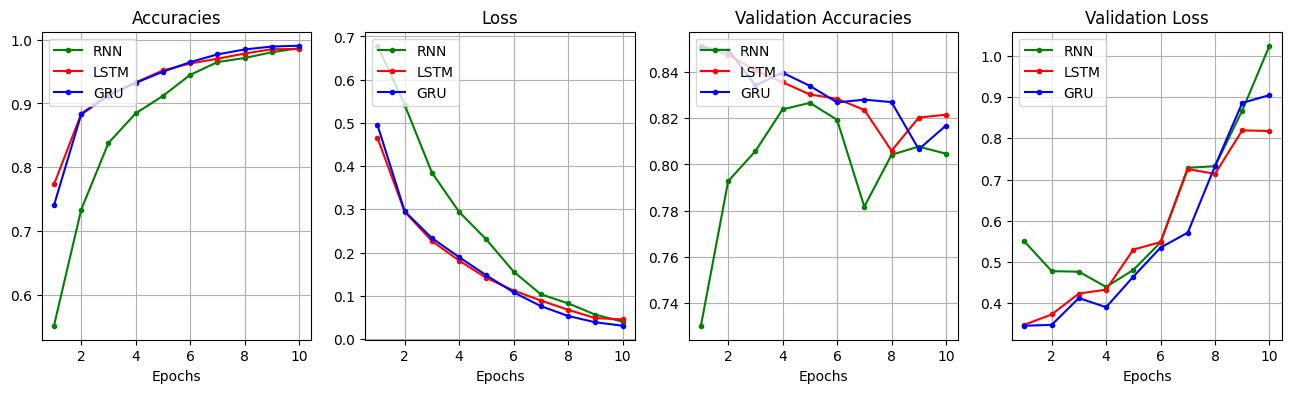

In [81]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.title('Accuracies')
plt.xlabel('Epochs')
plt.grid()
plt.plot(range(1,11), history.history['accuracy'], color = 'g', label = 'RNN',marker='.')
plt.plot(range(1,11), history_lstm.history['accuracy'], color = 'r', label = 'LSTM',marker='.')
plt.plot(range(1,11), history_gru.history['accuracy'], color = 'b', label = 'GRU',marker='.')
plt.legend(loc='upper left')

plt.subplot(1,4,2)
plt.title('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.plot(range(1,11), history.history['loss'], color = 'g', label = 'RNN',marker='.')
plt.plot(range(1,11), history_lstm.history['loss'], color = 'r', label = 'LSTM',marker='.')
plt.plot(range(1,11), history_gru.history['loss'], color = 'b', label = 'GRU',marker='.')
plt.legend(loc='upper left')

plt.subplot(1,4,3)
plt.title('Validation Accuracies')
plt.xlabel('Epochs')
plt.grid()
plt.plot(range(1,11), history.history['val_accuracy'], color = 'g', label = 'RNN',marker='.')
plt.plot(range(1,11), history_lstm.history['val_accuracy'], color = 'r', label = 'LSTM',marker='.')
plt.plot(range(1,11), history_gru.history['val_accuracy'], color = 'b', label = 'GRU',marker='.')
plt.legend(loc='upper left')

plt.subplot(1,4,4)
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.grid()
plt.plot(range(1,11), history.history['val_loss'], color = 'g', label = 'RNN',marker='.')
plt.plot(range(1,11), history_lstm.history['val_loss'], color = 'r', label = 'LSTM',marker='.')
plt.plot(range(1,11), history_gru.history['val_loss'], color = 'b', label = 'GRU',marker='.')
plt.legend(loc='upper left')

In [100]:
new1 = 'This was worst movie. Please do not watch it. Waste of money and time.'
new2 = 'A must watch movie. I loved to watch it. It was just amazing!'

In [101]:
def predict(model, text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_length, truncating = trunc_type)
    
    result = model.predict(pad, verbose = False)
    percent_pos = result[0,0]
    if round(percent_pos) == 0:
      return((1-percent_pos), 'NEGATIVE')
    else:
      return(percent_pos, 'POSITIVE')

In [104]:
predict(model_rnn, new1), predict(model_rnn, new2)

((0.9999763797422929, 'NEGATIVE'), (0.9768905, 'POSITIVE'))

In [105]:
predict(model_lstm, new1), predict(model_lstm, new2)

((0.9996257938037161, 'NEGATIVE'), (0.9964394, 'POSITIVE'))

In [106]:
predict(model_gru, new1), predict(model_gru, new2)

((0.9999829344505997, 'NEGATIVE'), (0.994364, 'POSITIVE'))